In [1]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt

In [2]:
def image(a1, a2, s):
    fig, ax = plt.subplots()
    ax.plot(a1, a2, '-', color = 'darkblue')
    ax.set_title(s)
    ax.grid()
    plt.show()

$
\frac{dx}{dt} = u\\
\frac{du}{dt} = x + 2v - \eta \left({\frac{x + \mu}A}\right) - \mu \left({\frac{x - \eta}B}\right)\\
\frac{dy}{dt} = v\\
\frac{dv}{dt} = y - 2u - \eta \left({\frac yA}\right) - \mu \left({\frac yB}\right)
$

### Решение схемой Эйлера

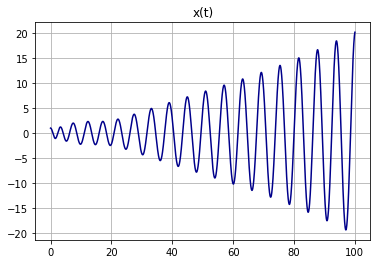

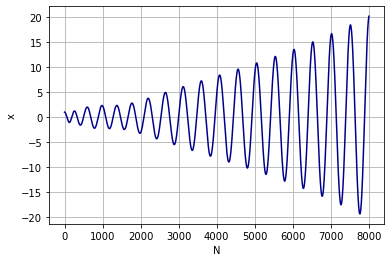

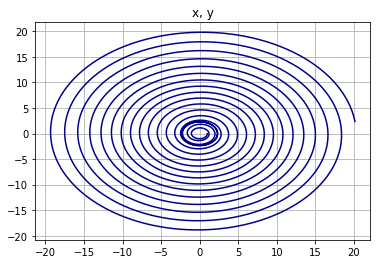

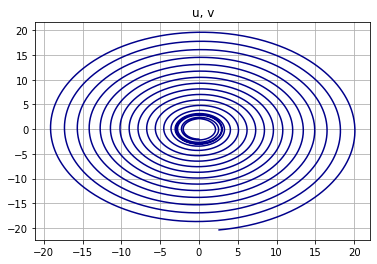

In [3]:
class data:
    def __init__(self, x, y, u, v):
        self.x, self.y, self.u, self.v = x, y, u, v

class solver:
    def __init__(self, eta, mu, d):
        self.eta, self.mu = eta, mu
        self.T = 100
        self.N = int(8e+3)
        self.h = self.T / self.N
        self.d = d
        
    def A_(self):
        x, y = self.d.x, self.d.y
        mu = self.mu
        
        return ((x + mu)**2 + y**2)**(3/2)

    def B_(self):
        x, y = self.d.x, self.d.y
        eta = self.eta
        
        return ((x - eta)**2 + y**2)**(3/2)

    def x_iter(self):
        x, y, u, v = self.d.x, self.d.y, self.d.u, self.d.v
        h = self.h
        
        return x + u * h

    def u_iter(self):
        x, y, u, v = self.d.x, self.d.y, self.d.u, self.d.v
        h = self.h
        eta, mu = self.eta, self.mu
        A = self.A_()
        B = self.B_()
        
        u_f = (x + 2 * v) - eta * ((x + mu) / A) - mu * ((x - eta) / B)
        return u + u_f * self.h

    def y_iter(self):
        x, y, u, v = self.d.x, self.d.y, self.d.u, self.d.v
        h = self.h
        
        return y + v * h

    def v_iter(self):
        x, y, u, v = self.d.x, self.d.y, self.d.u, self.d.v
        h = self.h
        eta, mu = self.eta, self.mu
        A = self.A_()
        B = self.B_()
        
        v_f = (y - 2 * u) - eta * (y / A) - mu * (y / B)
        return v + v_f * h
    
    def solve_(self):
        self.arr = []
        for i in range(self.N):
            x = self.x_iter()
            y = self.y_iter()
            u = self.u_iter()
            v = self.v_iter()
            self.d = data(x, y, u, v)
            self.arr.append(self.d)
        
    def image(self):
        arr_x, arr_y, arr_u, arr_v = [], [], [], []
        for i in range(self.N):
            arr_x.append(self.arr[i].x)
            arr_y.append(self.arr[i].y)
            arr_u.append(self.arr[i].u)
            arr_v.append(self.arr[i].v)

        arr_t = np.linspace(0, self.T, self.N)

        image(arr_t, arr_x, 'x(t)')
        plt.plot(np.arange(self.N), arr_x, color = 'darkblue')
        plt.xlabel('N')
        plt.ylabel('x')
        plt.grid()
        
        image(arr_x, arr_y, 'x, y')
        image(arr_u, arr_v, 'u, v')
        
    def solve(self):
        self.solve_()
        self.image()

mu = 0.012277471
eta = 1 - mu

x, y, u, v = 0.994, 0, 0, -2.00158510637908252240537862224
d = data(x, y, u, v)

S = solver(mu, eta, d)
S.solve()

### Решение методом Дормана-Принса

#### Задание параметров задачи и начальных условий

In [4]:
mu = 0.012277471
eta = 1 - mu

def A(x, y):
    return np.sqrt(((x + mu)**2 + y**2)**3)
def B(x, y):
    return np.sqrt(((x - eta)**2 + y**2)**3)

def g1(x, u, y, v):
    return u
def g2(x, u, y, v):
    return x + 2*v - eta * ((x + mu)/ A(x, y)) - mu * ((x - eta) / B(x, y))
def g3(x, u, y, v):
    return v
def g4(x, u, y, v):
    return y - 2*u - eta * (y / A(x, y)) - mu * (y / B(x, y))

def f(t, u):
    return np.array([f(u[0], u[1], u[2], u[3]) for f in [g1, g2, g3, g4]])

u0 = np.array([0.994, 0, 0, -2.00158510637908252240537862224])

#### Задание таблицы Бутчера

In [6]:
b = np.array([5179/57600, 0, -7571/16695, 393/640, -92097/339200, 187/2100, 1/40])
c = np.array([0, 1/5, 3/10, 4/5, 8/9, 1, 1])

A_ = np.zeros([6, 6])
A_[0, 0] = 1/5
A_[1, :2] = [3/40, 9/40]
A_[2, :3] = [44/45, -56/15, 32/9]
A_[3, :4] = [19372/6561, -25360/2187, 64448/6561, -212/729]
A_[4, :5] = [9017/3168, -355/33, -46732/5247, 49/176, -5103/18656]
A_[5, :6] = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]

#### Реализация метода Дормана-Принса

In [7]:
eps = 1e-3
def arg1(i):
    return t + c[i - 1]*h

def arg2(i, k):
    p = 0
    if i == 0:
        return p
    for j in range(i - 1):
        p += A_[i - 2, j]*k[j]
    return p

def dormand_prince(f, t, u, h):
    k = list(np.zeros(8))
    for i in range(7):
        k[i + 1] = h * f(arg1(i), u + arg2(i, k))

    # решение 5-го порядка точности
    y1 = u + A_[5, 0]*k[1] + A_[5, 1]*k[2] + A_[5, 2]*k[3] + A_[5, 3]*k[4] + A_[5, 4]*k[5] + A_[5, 5]*k[6]
    # решение для оценки ошибки
    y2 = u + b[0]*k[1] + b[1]*k[2] + b[2]*k[3] + b[3]*k[4] + b[4]*k[5] + b[5]*k[6] + b[6]*k[7]
    # оптимальный шаг
    h_opt = ((h**2) * eps / (2 * np.linalg.norm(y1 - y2))) ** (1/3)
    return (y1, h_opt)

#### Расчёт

In [8]:
u = u0
u_ = [u0]

t = 0
h = 1e-3
T = 170

while t < T:
    u, h = dormand_prince(f, t, u, h)
    u_.append(u)
    t += h

u_ = np.array(u_)

#### Графики

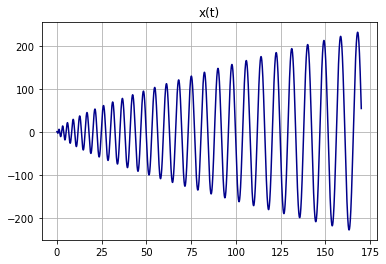

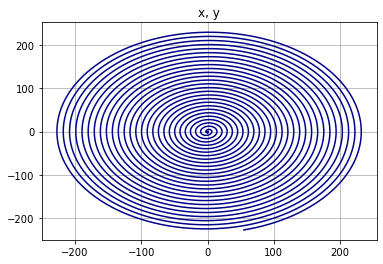

In [9]:
image(np.linspace(0, T, num = len(u_)), u_[:, 0], 'x(t)')
image(u_[:, 0], u_[:, 1], 'x, y')